In [1]:
# Import packages that are useful
import hopsworks
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

c:\Users\Merli\anaconda3\envs\id2223\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Log in to Hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194708
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Get the feature group of wine and create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine dataset, along daily added samples",
                                  labels=["quality"],
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/194708/fs/194627/fv/wine/version/1


In [4]:
# Create a train and test split, based on 20% training data 20% validation data and 20% test data. Randomly split
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(validation_size=0.2, test_size=0.2)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.41s) 


LinearRegression()

In [5]:
# See how the model performs
y_pred = model.predict(X_val)

# Round the predictions to the nearest integer
y_pred = y_pred.round()
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.5469924812030075


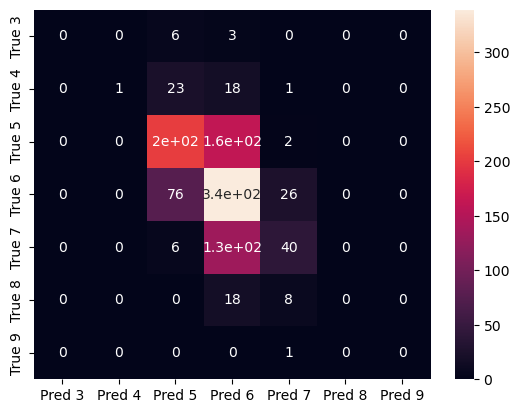

In [6]:
# Create a confusion matrix
df_cm = pd.DataFrame(results, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "Pred 9"])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()


In [7]:
# Try out a random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

# See how the random forest model performs
y_pred = rf.predict(X_val)
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)


0.5516917293233082


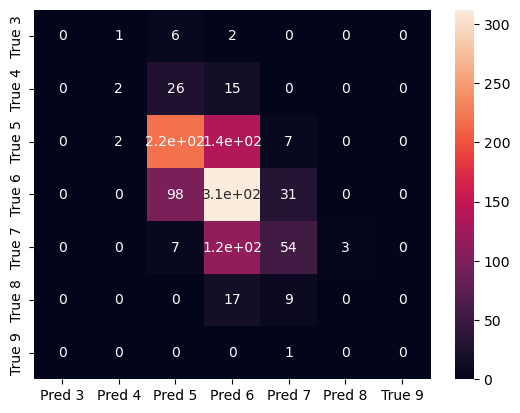

In [8]:
# Create a confusion matrix
df_cm = pd.DataFrame(results, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "True 9"])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()


In [9]:
# Try out a random forest regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())

# See how the random forest model performs
y_pred = rf.predict(X_val)
y_pred = y_pred.round()
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.5789473684210527


In [10]:
# Create a confusion matrix
df_cm = pd.DataFrame(results, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "Pred 9"])

In [11]:
# Create a simple naive bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train.values.ravel())

# See how the naive bayes model performs
y_pred = nb.predict(X_val)
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.412593984962406


In [12]:
# Train a KNN 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.values.ravel())

# See how the KNN model performs
y_pred = knn.predict(X_val)
metrics = classification_report(y_val, y_pred, output_dict=True)
results = confusion_matrix(y_val, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)


0.43703007518796994


0.5661971830985916


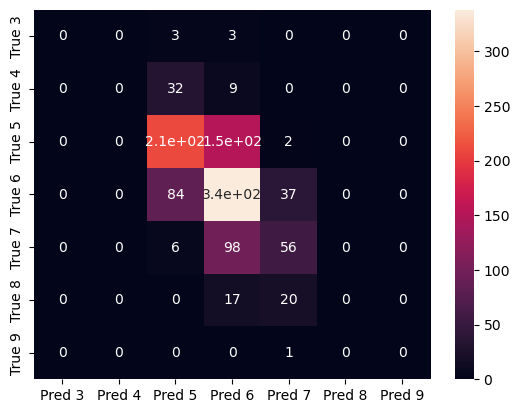

In [14]:
# The random forest classifier seems to perform the best, so we will use that model to predict the quality of the wine
y_pred = rf.predict(X_test)
y_pred = y_pred.round()
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Create a confusion matrix
df_cm = pd.DataFrame(results, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "Pred 9"])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [15]:
# We will now upload the random forst model to the registry
mr = project.get_model_registry()

# The directory will be wine_model
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save the model and the confusion matrix
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the input and output
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [00:41<00:00,  6.84s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/194708/models/wine_model/3


Model(name: 'wine_model', version: 3)